# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import udkm1Dsim as ud
u = ud.u  # import the pint unit registry from udkm1Dsim

In [2]:
%matplotlib widget
u.setup_matplotlib()  # use matplotlib with pint units

# Structure

In [ ]:
# #not required
# FeGd = ud.AtomMixed('FeGd', id='FeGd', name='FeGd', mag_amplitude=1, mag_phi=0*u.deg, mag_gamma=90*u.deg)
# FeGd.add_atom(Fe, .5)
# FeGd.add_atom(Gd, .5)

In [3]:
form_folder = 'combined_coefs/'

In [6]:
#all required atoms
Fe = ud.Atom('Fe', mag_amplitude=1, mag_phi=0*u.deg, mag_gamma=90*u.deg,
                   atomic_form_factor_path=form_folder + 'fe_comb.nff', magnetic_form_factor_path = form_folder + 'fe_comb.mf')
Gd = ud.Atom('Gd', mag_amplitude=1, mag_phi=0*u.deg, mag_gamma=90*u.deg,
                   atomic_form_factor_path=form_folder + 'gd_comb.nff', magnetic_form_factor_path = form_folder + 'gd_comb.mf')
Ta = ud.Atom('Ta', atomic_form_factor_source = 'henke')
Si = ud.Atom('Si', atomic_form_factor_source = 'henke')
N = ud.Atom('N', atomic_form_factor_source = 'henke')
print(Gd.get_atomic_form_factor(707.717))
print(Gd.get_magnetic_form_factor(707.717))

print(Fe.get_atomic_form_factor(1184.79))
print(Fe.get_magnetic_form_factor(1184.79))

(31.1698-11.2613j)
0j
(24.326647049525818-9.44673177028451j)
(-0.003979200460561696+0j)


In [7]:
#source: wiki 
density_SiN = 3.44*u.g/u.cm**3
SiN = ud.AtomMixed('SiN', id='SiN', name='Silicon-Nitride membrane')
SiN.add_atom(Si, 3/7)
SiN.add_atom(N, 4/7)

ground_layer = ud.AmorphousLayer('SiN', 'SiN base', 100*u.nm, density_SiN, atom=SiN)

In [8]:
density_Fe = 7874*u.kg/u.m**3
prop_Fe = {}
prop_Fe['heat_capacity'] = 449*u.J/u.kg/u.K
prop_Fe['therm_cond'] = 80*u.W/(u.m *u.K)

density_Gd = 7886*u.kg/u.m**3
prop_Gd = {}
prop_Gd['heat_capacity'] = 300*u.J/u.kg/u.K
prop_Gd['therm_cond'] = 11*u.W/(u.m *u.K)

layer_Fe = ud.AmorphousLayer('Fe', 'Fe amorphous', 0.41*u.nm, density_Fe, atom=Fe)
layer_Gd = ud.AmorphousLayer('Gd', 'Gd amorphous', 0.45*u.nm, density_Gd, atom=Gd)

In [9]:
# source: wikipedia and Lisa
density_Ta = 16.65e3*u.kg/u.m**3 

layer_Ta_finish = ud.AmorphousLayer('Ta', 'Ta amorphous', 2*u.nm, density_Ta, atom=Ta)

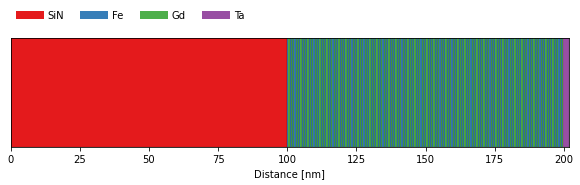

In [10]:
%matplotlib inline

# create a sub-structure
DL = ud.Structure('Fe/Gd layer')
DL.add_sub_structure(layer_Fe, 1)
DL.add_sub_structure(layer_Gd, 1)



S = ud.Structure('Fe/Pt multilayer')

S.add_sub_structure(ground_layer, 1)
S.add_sub_structure(DL, 116)
S.add_sub_structure(layer_Ta_finish, 1)

#plt.ioff()
S.visualize(fig_size = (10, 2))
#plt.ion()

## Magnetization

In [ ]:
dyn_mag = ud.XrayDynMag(S, True)
dyn_mag.disp_messages = True
dyn_mag.save_data = False
dyn_mag.set_polarization(1, 0)

In [ ]:
dyn_mag.energy = np.linspace(50,100,1000)*u.eV  # set two photon energies
# dyn_mag.energy = np.r_[50, 70]*u.eV  # set two photon energies
dyn_mag.theta = 90*u.deg  # angle of incidence
# dyn_mag.qz = np.r_[0.01:5:0.01]/u.nm  # qz range

In [ ]:
R_hom, R_hom_phi, T_hom, T_hom_phi = dyn_mag.homogeneous_reflectivity()  # this is the actual calculation

In [ ]:
fig, ax = plt.subplots(tight_layout = True)
# ax.semilogy(dyn_mag.energy, T_hom, label=r'$T_+$')
# ax.semilogy(dyn_mag.energy, T_hom_phi, label=r'$T_-$')
ax.plot(dyn_mag.energy, T_hom_phi - T_hom, label=r'$T_-$ - $T_+$')

# ax.semilogy(dyn_mag.qz[0, :], R_hom[0, :], label='{}'.format(dyn_mag.energy[0]))
# ax.semilogy(dyn_mag.qz[1, :], R_hom[1, :], label='{}'.format(dyn_mag.energy[1]))
ax.set_ylabel('Transmission')
ax.set_xlabel(r'energy (eV)')
ax.legend()

In [ ]:
%matplotlib widget
e,_, delta_beta = np.loadtxt(form_folder + 'gd_leonid.mf', unpack=True)
print('Max resonant energy Gd: %.2f' % e[np.argmax(np.abs(delta_beta))])
e,_, beta = np.loadtxt(form_folder + 'gd_leonid.nff', unpack=True)
e,_,delta_beta = np.loadtxt(form_folder + 'gd_leonid.mf', unpack=True)
plt.plot(e,beta+delta_beta)
plt.plot(e, beta-delta_beta)
plt.xlabel('energy / eV')
plt.ylabel('formfaktor beta, f\'\'')
print('Max resonant energy Fe: %.2f' % e[np.argmax(np.abs(delta_beta))])

## Determine figure of merit

### Fe/Gd multilayers

In [28]:
T = np.zeros(200)
P = np.zeros(200)
TP = np.zeros(200)

for i in range(0, 200):
    
    S = ud.Structure('Gd/Fe multilayer')
    S.add_sub_structure(ground_layer, 1)
    S.add_sub_structure(DL, i)
    S.add_sub_structure(layer_Ta_finish, 1)
    
    dyn_mag = ud.XrayDynMag(S, True)
    dyn_mag.disp_messages = False
    dyn_mag.save_data = False
    dyn_mag.set_polarization(1, 0)
    dyn_mag.energy = [706.97]*u.eV  # set two photon energies
    dyn_mag.theta = 90*u.deg  # angle of incidence
    _, _, T_hom, T_hom_phi = dyn_mag.homogeneous_reflectivity()  # this is the actual calculation
    T[i] = (T_hom + T_hom_phi) / 2
    P[i] = (T_hom - T_hom_phi) / (T_hom + T_hom_phi)
    TP[i] = T[i] * P[i]**2

incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
ana

incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
ana

Fe abs(TP^2): 3.533e-02


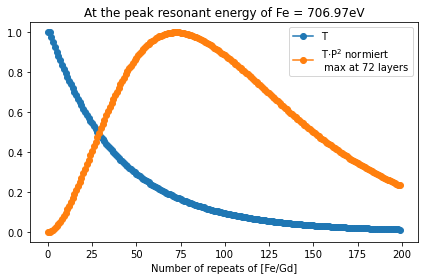

In [29]:
fig, ax = plt.subplots(tight_layout = True)
ax.plot(np.arange(0, 200, 1), T/np.max(T), 'o-', label = 'T')
# ax.plot(np.arange(0, 116, 1), P, label = 'P')
ax.plot(np.arange(0, 200, 1), TP/np.max(TP), 'o-', label = 'T$\cdot$P$^2$ normiert\n max at %d layers' % np.argmax(TP))
ax.legend()
ax.set_title('At the peak resonant energy of Fe = 706.97eV')
ax.set_xlabel('Number of repeats of [Fe/Gd]')
print('Fe abs(TP^2): %.3e' % np.max(TP))

In [30]:
T = np.zeros(200)
P = np.zeros(200)
TP = np.zeros(200)

for i in range(0, 200):
    
    S = ud.Structure('Gd/Fe multilayer')
    S.add_sub_structure(ground_layer, 1)
    S.add_sub_structure(DL, i)
    S.add_sub_structure(layer_Ta_finish, 1)
    
    dyn_mag = ud.XrayDynMag(S, True)
    dyn_mag.disp_messages = False
    dyn_mag.save_data = False
    dyn_mag.set_polarization(1, 0)
    dyn_mag.energy = [1184.79]*u.eV  # set two photon energies
    dyn_mag.theta = 90*u.deg  # angle of incidence
    _, _, T_hom, T_hom_phi = dyn_mag.homogeneous_reflectivity()  # this is the actual calculation
    T[i] = (T_hom + T_hom_phi) / 2
    P[i] = (T_hom - T_hom_phi) / (T_hom + T_hom_phi)
    TP[i] = T[i] * P[i]**2

incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
ana

incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized
incoming polarizations set to: sigma
ana

Gd TP^2 7.841e-02


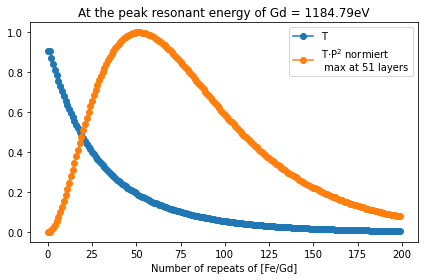

In [31]:
fig, ax = plt.subplots(tight_layout = True)
ax.plot(np.arange(0, 200, 1), T, 'o-', label = 'T')
# ax.plot(np.arange(0, 116, 1), P, label = 'P')
ax.plot(np.arange(0, 200, 1), TP/np.max(TP), 'o-', label = 'T$\cdot$P$^2$ normiert\n max at %d layers' % np.argmax(TP))
ax.legend()
ax.set_title('At the peak resonant energy of Gd = 1184.79eV')
ax.set_xlabel('Number of repeats of [Fe/Gd]')
print('Gd TP^2 %.3e' % np.max(TP))